In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import hydra
import pickle
from src.utils import get_cfg_from_ckpt_path 
from src.select_outputs_on_params import select_outputs_on_params
from sklearn.decomposition import PCA
import numpy as np
import scipy.ndimage
from tqdm import tqdm
from pathlib import Path
import yaml
from IPython.display import Markdown, display
from omegaconf import OmegaConf
from hydra.utils import call, instantiate
from pytorch_lightning import Trainer
import re
import os
import torch.nn as nn
import src.differentiable_fonc as DF
#from src.utils import *




In [2]:
plt.style.use('ggplot')

In [3]:
cmap = plt.get_cmap('viridis')

In [4]:
gpu = None
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [5]:
try:
    if dm_dict:
        print("Not reloading datamodule")

except:
    
    dm_dict = None
    old_n_components = 0
    print("Initializing datamodule")

Initializing datamodule


In [6]:
save_fig = False

## Functions

In [7]:
def load_model(model_ckpt_path: str,
               dm,
               device: str, 
               verbose: bool = True):

    cfg = get_cfg_from_ckpt_path(model_ckpt_path, pprint = False)
    
    lit_mod = hydra.utils.call(cfg.model)

    lit_mod.load_state_dict(torch.load(model_ckpt_path)["state_dict"])

    lit_mod.verbose = verbose
    
    lit_mod.depth_pre_treatment = dm.depth_pre_treatment

    lit_mod = lit_mod.to(device) # Move model to gpu for faster inference
    lit_mod = lit_mod.eval() # Model in eval mode
    for param in lit_mod.parameters():
        param.requires_grad = False  # Ensure no gradients are calculated for this model

    return lit_mod

In [8]:
def loading_datamodule(dm, device = "cpu"):
    
    dm.setup(stage="fit") 
    dm.setup(stage="test") 
    
    coords = dm.test_dataloader().dataset.input.coords
    
    train_ssp_ds = dm.train_dataloader().dataset.input
    train_ssp_arr = train_ssp_ds.dropna(dim='lat').data
    train_ssp_tens = torch.tensor(train_ssp_arr).float().to(device)
    

    test_ssp_ds = dm.test_dataloader().dataset.input
    test_ssp_arr = test_ssp_ds.dropna(dim='lat').data
    test_ssp_tens = torch.tensor(test_ssp_arr).float().to(device)
                
    return train_ssp_tens, test_ssp_tens, dm, coords

In [9]:
def loading_datamodule_phase(dm, device = "cpu", phase = "fit"):
    

    dm.setup(stage = phase) 
    
    if phase == "fit": 
        ssp_ds = dm.train_dataloader().dataset.input

    elif phase == "test":
        ssp_ds = dm.test_dataloader().dataset.input
      
        
    ssp_arr = ssp_ds.dropna(dim='lat').data
    ssp_tens = torch.tensor(ssp_arr).float().to(device)
    
    coords = ssp_ds.coords

                
    return ssp_arr, ssp_tens, dm, coords

In [10]:
def explicit_ecs_1D(ssp: torch.tensor,
                    depth_tens: torch.tensor,
                    tau = 100):
    
    ssp = ssp.unsqueeze(1).nan_to_num()          # This operation might be unnecessary if ssp already has the correct shape
    kernel = torch.tensor([-1.0, 1.0]).float().view(1, 1, 2).to(ssp.device)
    derivative = F.conv1d(ssp, kernel, padding=0)

    sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()

    sign_diff = F.conv1d(sign, kernel, padding=1)
    sign_change = F.tanh(10 * F.relu(-sign_diff))

    for pattern in ([1, 0, 1], [1, -1, 0, 0]):
        n = len(pattern)
        kernel_matrix = torch.eye(n)
        element_match = 0
        for i in range(n):
            kernel_element = kernel_matrix[i, :].view(1, 1, n).to(ssp.device)
            element_match += (F.conv1d(sign, kernel_element, padding=0) - pattern[i]) ** 2

        # Adjust padding to match the length of sign_change
        pattern_recognition = F.pad(element_match, (1, sign_change.shape[2] - element_match.shape[2] - 1), value=1.0)
        mask_discontinuity = 1 - F.relu(pattern_recognition + 1) * F.relu(1 - pattern_recognition)

        sign_change = sign_change * mask_discontinuity

    mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

    # Expand and align depth_array with the reduced shape of the input tensor
     
    depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1).to(ssp.device).type(sign_change.dtype)
    depth_array_tens[0, 0] = 0.0  # TODO: Handle the first depth value properly

    ecs_pred = (sign_change * mask).squeeze(dim=1)
    ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values
    return ecs_pred



In [11]:
def explicit_ecs_2D(ssp: torch.tensor,
                    depth_tens: torch.tensor,
                    batch: bool = False,
                    tau = 100):
    
    if batch:
        ssp = ssp.unsqueeze(1).nan_to_num()  
    
    else:
        ssp = ssp.unsqueeze(0).unsqueeze(0).nan_to_num()  
        
    kernel = torch.tensor([-1.0, 1.0]).float().view(1, 1, 2, 1).to(ssp.device)
    derivative = F.conv2d(ssp, kernel, padding=0)

    sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()

    sign_diff = F.conv2d(sign, kernel, padding=(1,0))
    sign_change = F.tanh(10 * F.relu(-sign_diff))

    for pattern in ([1, 0, 1], [1, -1, 0, 0]):
        n = len(pattern)
        kernel_matrix = torch.eye(n)
        element_match = 0
        for i in range(n):
            kernel_element = kernel_matrix[i, :].view(1, 1, n, 1).to(ssp.device)
            element_match += (F.conv2d(sign, kernel_element, padding=0) - pattern[i]) ** 2

        # Adjust padding to match the length of sign_change
        pattern_recognition = F.pad(element_match, (0,0,1, sign_change.shape[2] - element_match.shape[2] - 1), value=1.0)
        mask_discontinuity = 1 - F.relu(pattern_recognition + 1) * F.relu(1 - pattern_recognition)

        sign_change = sign_change * mask_discontinuity

    mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

    # Expand and align depth_array with the reduced shape of the input tensor
     
    depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1, 1).to(ssp.device).type(sign_change.dtype)
    depth_array_tens[0, 0] = 0.0  # TODO: Handle the first depth value properly

    ecs_pred = (sign_change * mask).squeeze(dim=1)
    ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values
    
    if not batch:
        ecs_pred = ecs_pred.squeeze(0)
        
    return ecs_pred

#ecs_2d = explicit_ecs_2D(torch.tensor(ssp_truth_unorm_test_arr[t,:,lat,:]).float(),torch.tensor(depth_array).float()).to(device) 



In [12]:
def explicit_ecs_3D(ssp: torch.tensor,
                    depth_tens: torch.tensor,
                    batch: bool = False,
                    tau = 100):
    
    if batch:
        ssp = ssp.unsqueeze(1).nan_to_num()  
    
    else:
        ssp = ssp.unsqueeze(0).unsqueeze(0).nan_to_num()       
        
    kernel = torch.tensor([-1.0, 1.0]).float().view(1,1,2,1,1).to(ssp.device)
    derivative = F.conv3d(ssp, kernel, padding=(0,0,0))

    #sign = DF.differentiable_sign(derivative)

    sign = torch.sign(derivative) + F.tanh(tau * derivative) - F.tanh(tau * derivative).detach()
    #print("After torch.sign (sign):", sign.requires_grad, sign.grad_fn)


    sign_diff = F.conv3d(sign, kernel, padding=(1,0,0))
    sign_change = F.tanh(10*F.relu(-sign_diff))

    for pattern in ([1, 0, 1], [1, -1, 0, 0]):  
        n = len(pattern)
        kernel_matrix = torch.eye(n)
        element_match = 0
        for i in range(n):
            kernel_element = kernel_matrix[i,:].view(1,1,n,1,1).to(ssp.device)
            element_match = element_match + (F.conv3d(sign, kernel_element, padding=(0,0,0)) - pattern[i])**2

        pattern_recognition = F.pad( element_match, (0, 0, 0, 0, 1, (sign_change.shape[2]- element_match.shape[2]) - 1),value=1.)    



        mask_discontinuity = 1 - F.relu(pattern_recognition+1) * F.relu(1-pattern_recognition)

        sign_change = sign_change * mask_discontinuity


    mask = F.relu(2 - torch.cumsum(sign_change, dim=2))

    depth_array_tens = depth_tens[:mask.shape[2]].view(1,-1,1,1).to(ssp.device).type(sign_change.dtype)
    depth_array_tens[0,0,0,0] = 0.  ##TODO the true first z value is equal to 48cm. It may have to be considered that way
    ecs_pred = (sign_change * mask ).squeeze(dim=1)
    ecs_pred = (ecs_pred * depth_array_tens).max(dim=1).values 
    
    
    if batch:
        ecs_pred = ecs_pred.squeeze(0)
        
    return ecs_pred



In [13]:
def norm_ssp(ssp_arr:np.array, norm_stats: dict, verbose: True):

    if verbose:
        print(norm_stats.method)

    if norm_stats.method == "mean_std_along_depth":
        mean,std = norm_stats.params.values()
        ssp_unorm_arr = (ssp_arr - mean.data.reshape(1,1,1,-1)/std.data.reshape(1,1,1,-1))
        
    elif norm_stats.method == "mean_std":
        mean,std = norm_stats.params.values()
        ssp_unorm_arr = (ssp_arr - mean)/std
    
    elif norm_stats.method == "min_max":
        x_min,x_max = norm_stats.params.values()
        ssp_unorm_arr = (ssp_arr - x_min)/(x_max-x_min)
        
    return ssp_unorm_arr

In [14]:
def unorm_ssp(ssp_arr:np.array, dm, verbose = True):

    if verbose:
        print(dm.norm_stats.method)

    if dm.norm_stats.method == "mean_std_along_depth":
        mean,std = dm.norm_stats.params.values()
        ssp_unorm_arr = (ssp_arr*std.data.reshape(1,1,1,-1)) + mean.data.reshape(1,1,1,-1) 
        
    elif dm.norm_stats.method == "mean_std":
        mean,std = dm.norm_stats.params.values()
        ssp_unorm_arr = ssp_arr*std + mean
    
    elif dm.norm_stats.method == "min_max":
        x_min,x_max = dm.norm_stats.params.values()

        if dm.depth_pre_treatment["method"] == "pca":
            pca = dm.depth_pre_treatment["fitted_pca"]
            ssp_arr = pca.transform(ssp_arr.transpose(1,0))
            ssp_unorm_arr = ssp_arr*(x_max-x_min) + x_min
            ssp_unorm_arr = pca.inverse_transform(ssp_unorm_arr).transpose(1,0)
                
        else:
            ssp_unorm_arr =ssp_arr*(x_max-x_min) + x_min

            
        
    return ssp_unorm_arr

In [15]:
def plot_imgs_depth_lon_2D(ssp_truth_unorm_test_arr,
                           ssp_pca_unorm_test_arr,
                           ssp_ae_unorm_test_arr, 
                           ecs_truth, 
                           ecs_pred_pca, 
                           ecs_pred_ae, 
                           depth_array,
                           coords,
                           n_components, 
                           compression_rate_pca, 
                           compression_rate_ae, 
                           bottleneck_shape):
    
    fig,axs = plt.subplots(1,3,figsize=(25,6), gridspec_kw={'width_ratios': [1, 1, 1]})

    im1 = axs[0].imshow(ssp_truth_unorm_test_arr, cmap=cmap, aspect = "equal")  
    im2 = axs[1].imshow(ssp_pca_unorm_test_arr, cmap=cmap, aspect = "equal")
    im3 = axs[2].imshow(ssp_ae_unorm_test_arr, cmap=cmap, aspect = "equal")


    y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int)
    y_tick_values = depth_array[y_tick_indices]

    x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
    x_tick_values = coords["lon"].data[x_tick_indices]

        
        
        
    indices_ecs_truth = np.searchsorted(depth_array, ecs_truth.detach().cpu().numpy())
    indices_ecs_pca = np.searchsorted(depth_array, ecs_pred_pca.detach().cpu().numpy())
    indices_ecs_ae = np.searchsorted(depth_array, ecs_pred_ae.detach().cpu().numpy())


    axs[0].plot(indices_ecs_truth, label = "ECS")
    axs[1].plot(indices_ecs_pca, label = f"ECS RMSE={np.round(torch.sqrt(torch.mean((ecs_truth-ecs_pred_pca)**2)).item(),2)}m")
    axs[2].plot(indices_ecs_ae, label = f"ECS RMSE ={np.round(torch.sqrt(torch.mean((ecs_truth-ecs_pred_ae)**2)).item(),2)}m")

    for ax in axs[:]:
        ax.set_yticks(y_tick_indices)
        ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
        
        ax.set_xticks(x_tick_indices)
        ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])
        ax.grid(False)
        
        ax.set_xlabel("Longitude (°)")
        ax.legend(loc = "lower left")
        
        #ax.invert_yaxis() 

    axs[0].set_title("Ground truth", fontsize = 10)
    axs[1].set_title(f"PCA reconstruction\n{n_components} depth components, compression rate: {np.round(compression_rate_pca,2)} \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr-ssp_pca_unorm_test_arr)**2)/np.sum(ssp_truth_unorm_test_arr**2))*100,8)}%", fontsize = 10)
    axs[2].set_title(f"AE reconstruction\nbottleneck shape:{list(bottleneck_shape)}, compression rate: {np.round(compression_rate_ae,2)} \nRMSE={np.round(np.sqrt(np.mean((ssp_truth_unorm_test_arr-ssp_ae_unorm_test_arr)**2)/np.sum(ssp_truth_unorm_test_arr**2))*100,8)}%", fontsize = 10)

    axs[0].set_ylabel('Depth (m)')


    cbar = fig.colorbar(im3, ax=axs.ravel().tolist(), shrink = 0.5, aspect=12, pad = 0.02)
    cbar.set_label("m/s")

    min_val, max_val = im3.get_clim()
    ticks = np.linspace(min_val, max_val, 4)
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{tick:.0f}' for tick in ticks])

    #fig.tight_layout()

    fig.suptitle(f"Sound Speed reconstruction",x = 0.45, y = 0.80)


## Model without training

params:

            save_dir_name=$save_dir \
            trainer.max_epochs=$max_epoch \
            datamodule.depth_pre_treatment.method=$pre_treatment_method \
            datamodule.depth_pre_treatment.params=$n_components \
            model_config.model_hparams.AE_CNN_3D.channels_list=$chnls \
            model_config.model_hparams.AE_CNN_3D.n_conv_per_layer=1 \
            model_config.model_hparams.AE_CNN_3D.padding=reflect \
            model_config.model_hparams.AE_CNN_3D.interp_size=25 \
            model_config.model_hparams.AE_CNN_3D.upsample_mode=trilinear \
            model_config.model_hparams.AE_CNN_3D.pooling_dim=spatial \
            model_config.model_hparams.AE_CNN_3D.act_fn_str=Relu \
            model_config.model_hparams.AE_CNN_3D.final_act_fn_str=Relu \
            model.opt_fn.lr=0.001 \
            model.loss_weight.prediction_weight=$pred_weight \
            model.loss_weight.gradient_weight=$grad_weight \
            model.loss_weight.ecs_weight=$ecs_weight \
            model.loss_weight.fft_weight=$fft_weight \
            model.loss_weight.weighted_weight=$weighted_weight \

In [16]:
# from datetime import datetime
# def now_resolver(value: str):
#     # Check if the value is in the format ${now:%Y-%m-%d_%H-%M}
#     if value.startswith('${now:') and value.endswith('}'):
#         # Extract the datetime format
#         format_string = value[6:-1]  # Extract part after '${now:' and before '}'
#         return datetime.now().strftime(format_string)
#     return value  # Return the value unchanged if not a 'now' placeholder

In [17]:


cfg_path = "config/xp/autoencoder_V2.yaml"
cfg = OmegaConf.load(cfg_path)
display(Markdown("""```yaml\n\n""" +yaml.dump(OmegaConf.to_container(cfg), default_flow_style=None, indent=2)+"""\n\n```"""))

```yaml

datamodule:
  _target_: src.autoencoder_datamodule.AutoEncoderDatamodule_${dimensions}
  depth_pre_treatment: {method: none, params: 50}
  dl_kw: {batch_size: '${model_config.batch_size.${dimensions}}', num_workers: 2}
  dtype_str: ${dtype}
  input_da: {_target_: src.utils.load_ssp_da, ssf_da_path: '${paths.sound}'}
  manage_nan: suppress
  n_profiles: null
  norm_stats: {method: mean_std, params: '${normalization.${datamodule.norm_stats.method}}'}
dimensions: 3D
dtype: float32
entrypoints:
- {_target_: pytorch_lightning.seed_everything, seed: 333}
- {_target_: src.train.base_training, dim: '${dimensions}', dm: '${datamodule}', lit_mod: '${model}',
  trainer: '${trainer}'}
hydra:
  job:
    env_set: {CUDA_VISIBLE_DEVICES: 1}
  run: {dir: '${trainer.logger.save_dir}/${trainer.logger.name}/${trainer.logger.version}'}
model:
  _target_: src.autoencoder_V2.AutoEncoder
  dim: ${dimensions}
  loss_weight: {ecs_weight: 0, fft_weight: 0, gradient_weight: 0, inflection_pos_weight: 0,
    inflection_value_weight: 0, max_position_weight: 0, max_value_weight: 0, prediction_weight: 0.5,
    weighted_weight: 1}
  model_hparams: ${model_config.model_hparams.${model.model_name}}
  model_name: ${model_architecture}_${dimensions}
  opt_fn: {T_max: '${trainer.max_epochs}', _partial_: true, _target_: src.ecs_classification.ECS_classification.cosanneal_lr_adamw,
    lr: 0.001, weight_decay: 0.001}
model_architecture: AE_CNN
model_config:
  accumulate_grad_batches: {1D: 1, 2D: 1, 3D: 1}
  batch_size: {1D: 512, 2D: 32, 3D: 4}
  model_hparams:
    AE_CNN_1D:
      act_fn_str: Elu
      channels_list: [1, 1]
      dropout_proba: 0
      final_act_fn_str: Linear
      final_upsample_str: upsample_pooling
      interp_size: 0
      latent_size: 9
      linear_layer: false
      n_conv_per_layer: 1
      padding: linear
      pooling: None
      pooling_dim: spatial
      upsample_mode: trilinear
    AE_CNN_2D:
      act_fn_str: Elu
      channels_list: [1, 1]
      dropout_proba: 0
      final_act_fn_str: Linear
      final_upsample_str: upsample_pooling
      interp_size: 0
      latent_size: 50
      linear_layer: false
      n_conv_per_layer: 1
      padding: reflect
      pooling: None
      pooling_dim: spatial
      upsample_mode: trilinear
    AE_CNN_3D:
      act_fn_str: Elu
      channels_list: [1, 1]
      dropout_proba: 0
      final_act_fn_str: Linear
      final_upsample_str: upsample_pooling
      interp_size: 0
      latent_size: 50
      linear_layer: false
      n_conv_per_layer: 1
      padding: reflect
      pooling: None
      pooling_dim: spatial
      upsample_mode: trilinear
  save_dir: {AE_CNN: 'channels_${model.model_hparams.channels_list}/upsample_mode_${model.model_hparams.upsample_mode}/linear_later_${model.model_hparams.linear_layer}_lattent_size_${model.model_hparams.latent_size}/${model.model_hparams.n_conv_per_layer}_conv_per_layer/padding_${model.model_hparams.padding}/interp_size_${model.model_hparams.interp_size}/pooling_${model.model_hparams.pooling}_on_dim_${model.model_hparams.pooling_dim}/final_upsample_${model.model_hparams.final_upsample_str}/act_fn_${model.model_hparams.act_fn_str}_final_act_fn_${model.model_hparams.final_act_fn_str}',
    AE_CNN_pool_1D: 'latent_dim_${model.model_hparams.latent_dim}_pooling_${model.model_hparams.num_layers}_${model.model_hparams.pooling_str}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}',
    AE_CNN_pool_2D: 'latent_dim_${model.model_hparams.latent_dim}_pooling_${model.model_hparams.num_layers}_${model.model_hparams.pooling_str}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}/act_fn_${model.model_hparams.act_fn_str}_final_act_fn_${model.model_hparams.final_act_fn_str}_normalization_${datamodule.norm_stats.method}'}
normalization:
  mean_std: {mean: null, std: null}
  mean_std_along_depth: {mean: null, std: null}
  min_max: {x_max: null, x_min: null}
paths: {sound: /DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc}
patience: 5
root_save_dir: "/homes/o23gauvr/Documents/th\xE8se/code/FASCINATION/outputs"
save_dir_name: test
trainer:
  _target_: pytorch_lightning.Trainer
  accelerator: gpu
  accumulate_grad_batches: ${model_config.accumulate_grad_batches.${dimensions}}
  callbacks:
  - {_target_: pytorch_lightning.callbacks.LearningRateMonitor}
  - {_target_: pytorch_lightning.callbacks.ModelCheckpoint, filename: '{val_loss:.2f}-{epoch:02d}',
    mode: min, monitor: val_loss, save_top_k: 1}
  - {_target_: pytorch_lightning.callbacks.EarlyStopping, min_delta: 1.0e-06, monitor: val_loss,
    patience: '${trainer.max_epochs}', verbose: true}
  check_val_every_n_epoch: 1
  devices: 1
  inference_mode: false
  logger: {_target_: pytorch_lightning.loggers.tensorboard.TensorBoardLogger, log_graph: true,
    name: '${save_dir_name}', save_dir: '${root_save_dir}/AE/${model.model_name}',
    version: 'pred_${model.loss_weight.prediction_weight}_grad_${model.loss_weight.gradient_weight}_max_pos_${model.loss_weight.max_position_weight}_max_value_${model.loss_weight.max_value_weight}_fft_${model.loss_weight.fft_weight}_weighted_${model.loss_weight.weighted_weight}_inflection_pos_${model.loss_weight.inflection_pos_weight}_inflection_value_${model.loss_weight.inflection_value_weight}/depth_pre_treatment_${datamodule.depth_pre_treatment.method}_n_components_${datamodule.depth_pre_treatment.params}/${model_config.save_dir.${model_architecture}}/lr_${model.opt_fn.lr}/normalization_${datamodule.norm_stats.method}/manage_nan_${datamodule.manage_nan}/n_profiles_${datamodule.n_profiles}/${now:%Y-%m-%d_%H-%M}'}
  max_epochs: 10
  min_epochs: 0


```

In [18]:
trainer = Trainer(inference_mode = True)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/DATASET/envs/o23gauvr/miniconda3/envs/fsc_env/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /DATASET/envs/o23gauvr/miniconda3/envs/fsc_env/lib/p ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
dm_dict = cfg.datamodule
dm = call(dm_dict) #hydra.utils.call(dm_dict)
train_ssp_tens, test_ssp_tens, dm, coords = loading_datamodule(dm)

In [20]:
# channels_list = [[1,8],[1,8,8],[1,8,8,8],[1,8,8,8,8]]

# for chn in channels_list: 
#     cfg.model.model_hparams.channels_list = chn
#     lit_mod = call(cfg.model)

#     trainer.test(lit_mod, dataloaders=dm)

#     checkpoint_path = f"{cfg.trainer.logger.save_dir}/untrained_models/{cfg.model_config.save_dir[f'{cfg.model_architecture}']}"
#     os.makedirs(checkpoint_path, exist_ok=True)

#     model_path = f"{checkpoint_path}/model.ckpt"
#     torch.save(lit_mod.state_dict(), model_path)
#     print(f"Model checkpoint saved at {checkpoint_path}")


# Only pool upsample model

In [ ]:
class NoConvAE(nn.Module):
    def __init__(self, 
                 n:int, 
                 pooling_dim:str = "spatial",
                 pooling_mode:str = "Avg"):


        super().__init__()

        self.upsample_mode = "trilinear"


        if pooling_dim == "all":
            pool_str = 2
            
        elif pooling_dim == "depth":
            pool_str = (2,1,1)

        elif pooling_dim == "spatial":
            pool_str = (1,2,2)
        
        elif pooling_dim == None:
            pool_str = 1




        pooling_dict = {"Avg": nn.AvgPool3d(kernel_size= 1,stride=pool_str, padding = 0),
                        "Max": nn.MaxPool3d(kernel_size=1, stride=pool_str, padding = 0),
                        "None": nn.Identity()}     
        
        upsample_dict = {"Avg": nn.Upsample(scale_factor = pool_str, mode = self.upsample_mode),
                        "Max":  nn.Upsample(scale_factor = pool_str, mode = self.upsample_mode),
                        "None": nn.Identity()}   
        
        pool_layer = pooling_dict[pooling_mode]
        upsample_layer = upsample_dict[pooling_mode]

            

        self.encoder = nn.Sequential(*[pool_layer for i in range(n)])
    
        self.decoder = nn.Sequential(*[upsample_layer for i in range(n-1)])

        self.decoder.append(nn.Upsample(size=None, mode=self.upsample_mode))

    
    def forward(self,x):

        self.decoder[-1].size = x.shape[-3:]

        x = x.unsqueeze(1)

        self.bottleneck = self.encoder(x)

        self.output = self.decoder(self.bottleneck).squeeze(1)
    

        return self.output

        




: 

In [ ]:
pca_list = [3,10,50,107]

ae_rmse_dict = {"SSP":{},
                "ECS":{}}

for n_components in tqdm(pca_list):

    input_shape = test_ssp_tens.shape
    pca = PCA(n_components = n_components, svd_solver = 'auto')
    pca.fit(train_ssp_tens.permute(0,2,3,1).reshape(-1,input_shape[1]))
    
    dif_pca = DF.Differentiable4dPCA(pca, test_ssp_tens.shape)
    
    for keys in ae_rmse_dict.keys():
        ae_rmse_dict[keys][f"Pool_upsample_pca_{n_components}"] = {}

    for n_layer in tqdm(range(5)): 
        
        model_ae = NoConvAE(n_layer,pooling_mode="Avg")
        
        reduced_test_ssp_tens = dif_pca.transform(test_ssp_tens)
        reduced_pred_ssp_tens = model_ae(reduced_test_ssp_tens)
        bottleneck_shape = model_ae.encoder(reduced_test_ssp_tens).shape
        
        pred_ssp_tens = dif_pca.inverse_transform(reduced_pred_ssp_tens)
        
        pred_ssp_tens = torch.tensor(unorm_ssp(pred_ssp_tens.cpu().numpy(), dm)).to(device)
        test_ssp_tens = torch.tensor(unorm_ssp(test_ssp_tens.cpu().numpy(), dm)).to(device)

        max_ssp_truth_idx = torch.tensor(np.nanargmax(test_ssp_tens.cpu().numpy(), axis=1))
        ecs_truth = dm.depth_array[max_ssp_truth_idx]        

        max_ssp_pred_idx = torch.tensor(np.nanargmax(pred_ssp_tens.cpu().numpy(), axis=1))
        ecs_pred = dm.depth_array[max_ssp_pred_idx]
        
        ae_rmse_dict["SSP"][f"Pool_upsample_pca_{n_components}"][bottleneck_shape] = torch.sqrt(torch.mean((test_ssp_tens - pred_ssp_tens) ** 2)).item()
        ae_rmse_dict["ECS"][f"Pool_upsample_pca_{n_components}"][bottleneck_shape] = np.sqrt(np.mean((ecs_truth - ecs_pred) ** 2))
        
        t, lat = 10, 10
        lon = 100

        fig, axs = plt.subplots(2, 2, figsize=(13, 10))

        axs[0, 0].plot(test_ssp_tens[t, :, lat, lon], dm.depth_array)  
        axs[0, 1].plot(pred_ssp_tens[t, :, lat, lon], dm.depth_array)
        axs[1, 0].plot(reduced_test_ssp_tens[t, :, lat, lon], np.arange(1, n_components + 1))
        axs[1, 1].plot(reduced_pred_ssp_tens[t, :, lat, lon], np.arange(1, n_components + 1))

        axs[0, 0].set_title("Ground truth", fontsize=12)
        axs[0, 1].set_title("Reconstruction", fontsize=12)
        axs[1, 0].set_title("PCA Reduced Ground truth", fontsize=12)
        axs[1, 1].set_title("PCA Reduced Reconstruction", fontsize=12)

        for axis in axs[0, :]:
            axis.set_xlabel("m/s")   
            axis.set_ylabel("Depth (m)")  
            axis.invert_yaxis()

        for axis in axs[1, :]:
            axis.set_xlabel("")   
            axis.set_ylabel("PCA component")
            axis.set_yticks(np.linspace(1, n_components, min(n_components, 5), dtype=int))  # Set y-ticks to be min(n_components, 5) evenly spaced integers

        plt.subplots_adjust(hspace=0.25)

        fig.suptitle(f"Sound Speed reconstruction", x=0.5, y=0.95, fontsize=15)
        
        plt.show()


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:

with open('pickle/pooling_upsampling_pca_pre_treatment_rmse.pkl', 'wb') as f:
    pickle.dump(ae_rmse_dict, f)

In [ ]:
ae_rmse_dict

{'SSP': {'Pool_upsample_pca_3': {torch.Size([37, 3, 174, 240]): 0.9660316109657288,
   torch.Size([37, 3, 87, 120]): 0.833315908908844,
   torch.Size([37, 3, 44, 60]): 0.8196558356285095,
   torch.Size([37, 3, 22, 30]): 0.820619523525238,
   torch.Size([37, 3, 11, 15]): 0.823032796382904},
  'Pool_upsample_pca_10': {torch.Size([37, 10, 174, 240]): 0.9864063858985901,
   torch.Size([37, 10, 87, 120]): 0.9652799963951111,
   torch.Size([37, 10, 44, 60]): 0.9369967579841614,
   torch.Size([37, 10, 22, 30]): 0.9474939703941345,
   torch.Size([37, 10, 11, 15]): 0.9555559158325195},
  'Pool_upsample_pca_50': {torch.Size([37, 50, 174, 240]): 0.9918687343597412,
   torch.Size([37, 50, 87, 120]): 0.9084571003913879,
   torch.Size([37, 50, 44, 60]): 0.883794367313385,
   torch.Size([37, 50, 22, 30]): 0.885693371295929,
   torch.Size([37, 50, 11, 15]): 0.8984529972076416},
  'Pool_upsample_pca_107': {torch.Size([37, 107, 174, 240]): 0.9925265908241272,
   torch.Size([37, 107, 87, 120]): 0.8291304

In [ ]:
model_ae = NoConvAE(3,pooling_mode="Avg")

In [ ]:
model_ae.encoder(test_ssp_tens).shape

torch.Size([37, 107, 22, 30])

In [ ]:
input_shape = test_ssp_tens.shape
n_components = 50
pca = PCA(n_components = n_components, svd_solver = 'auto')
pca.fit(train_ssp_tens.permute(0,2,3,1).reshape(-1,input_shape[1]))

PCA(n_components=50)

In [ ]:
dif_pca = DF.Differentiable4dPCA(pca, test_ssp_tens.shape)

In [ ]:
reduced_test_ssp_tens = dif_pca.transform(test_ssp_tens)

In [ ]:
reduced_pred_ssp_tens = model_ae(reduced_test_ssp_tens)

In [ ]:
pred_ssp_tens = dif_pca.inverse_transform(reduced_pred_ssp_tens)

In [ ]:
model_ae.bottleneck.shape

torch.Size([37, 1, 50, 22, 30])

In [ ]:
depth_array = coords["z"].data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


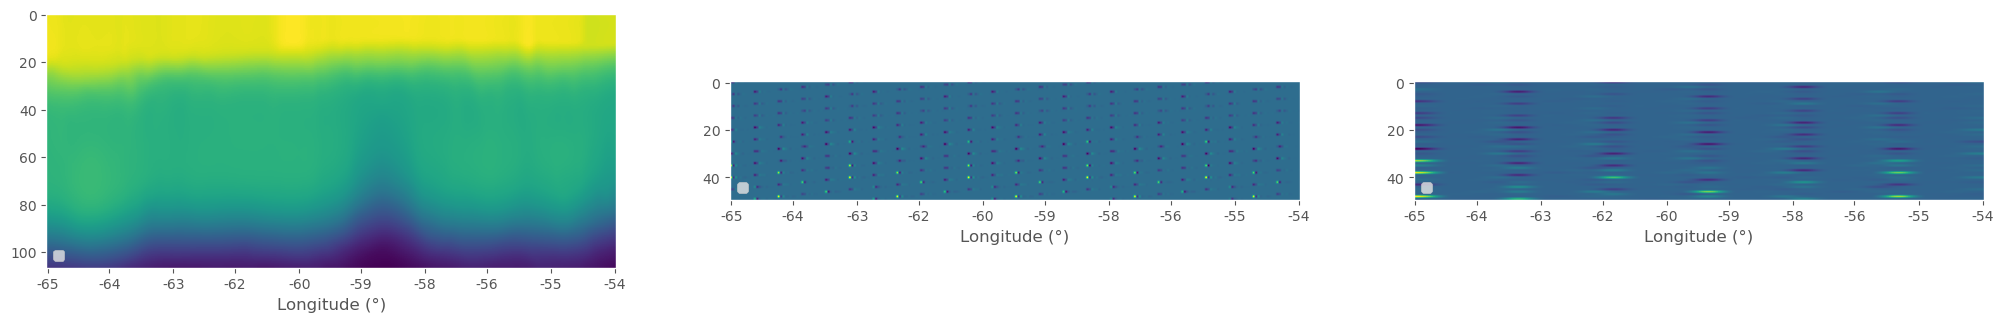

In [ ]:
t,lat = 10,10

fig,axs = plt.subplots(1,3,figsize=(25,6), gridspec_kw={'width_ratios': [1, 1, 1]})

im1 = axs[0].imshow(test_ssp_tens[t,:,lat,:], cmap=cmap, aspect = "equal")  
im2 = axs[1].imshow(reduced_test_ssp_tens[t,:,lat,:], cmap=cmap, aspect = "equal")
im3 = axs[2].imshow(reduced_pred_ssp_tens[t,:,lat,:], cmap=cmap, aspect = "equal")


y_tick_indices = np.linspace(0, len(depth_array) - 1, 5, dtype=int)
y_tick_values = depth_array[y_tick_indices]

x_tick_indices = np.linspace(0, len(coords["lon"].data) - 1, 10, dtype=int)
x_tick_values = coords["lon"].data[x_tick_indices]


for ax in axs.flatten():
        # ax.set_yticks(y_tick_indices)
        # ax.set_yticklabels([str(y) for y in y_tick_values.astype((np.int16))])
        
        ax.set_xticks(x_tick_indices)
        ax.set_xticklabels([str(y) for y in x_tick_values.astype((np.int16))])

        ax.grid(False)
        
        ax.set_xlabel("Longitude (°)")
        ax.legend(loc = "lower left")


Text(0.5, 0.95, 'Sound Speed reconstruction')

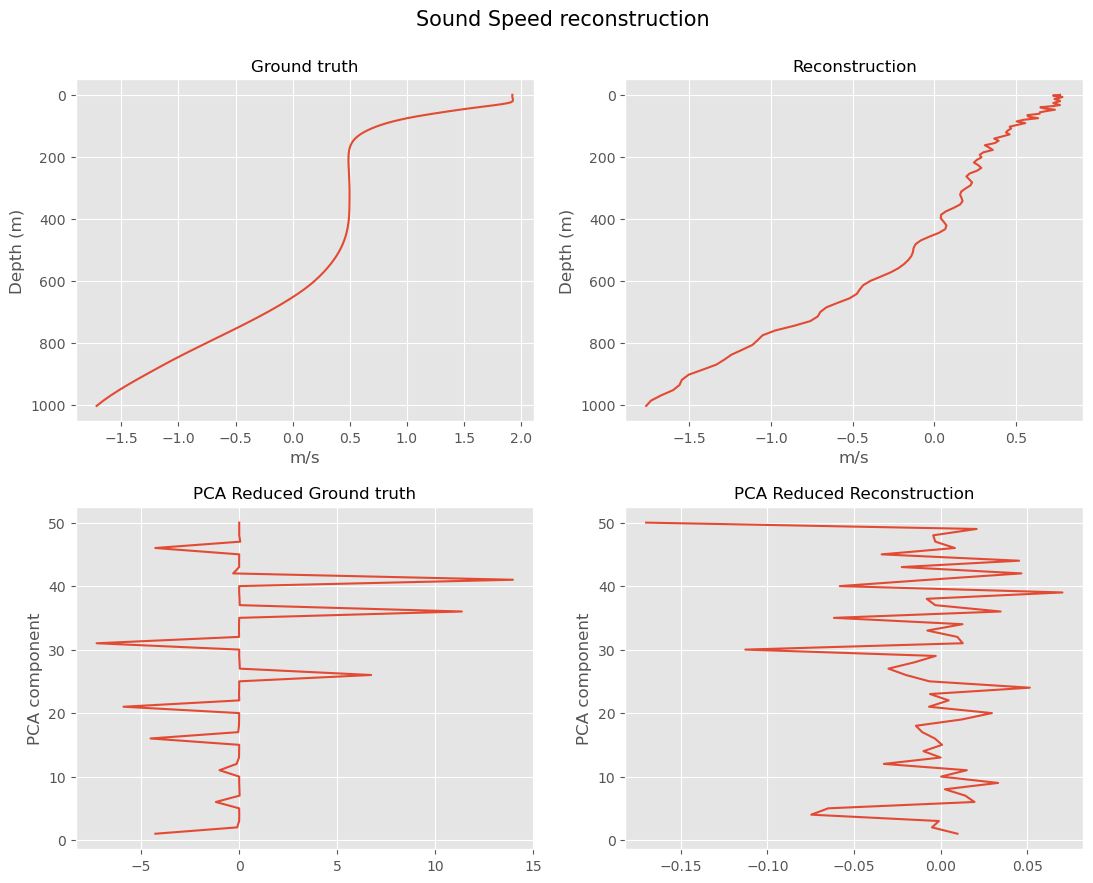

In [ ]:
t,lat = 10,10
lon = 100

fig,axs = plt.subplots(2,2,figsize=(13,10))

axs[0,0].plot(test_ssp_tens[t,:,lat,lon],depth_array)  
axs[0,1].plot(pred_ssp_tens[t,:,lat,lon],depth_array)
axs[1,0].plot(reduced_test_ssp_tens[t,:,lat,lon], np.arange(1,n_components+1))
axs[1,1].plot(reduced_pred_ssp_tens[t,:,lat,lon],np.arange(1,n_components+1))

axs[0,0].set_title("Ground truth", fontsize = 12)
axs[0,1].set_title("Reconstruction", fontsize = 12)
axs[1,0].set_title("PCA Reduced Ground truth", fontsize = 12)
axs[1,1].set_title("PCA Reduced Reconstruction", fontsize = 12)


        
for axis in axs[0,:]:
        axis.set_xlabel("m/s")   
        axis.set_ylabel("Depth (m)")  
        axis.invert_yaxis()
 

for axis in axs[1,:]:
        axis.set_xlabel("")   
        axis.set_ylabel("PCA component")

plt.subplots_adjust(hspace=0.25)

fig.suptitle(f"Sound Speed reconstruction",x = 0.5, y = 0.95,fontsize = 15)
  
